In [3]:
# import torch
# from torch.utils.data import DataLoader

import sys, os
rootdir = '../..'
sys.path.append(rootdir)

# import config_dataset
# from modules.neural_net.backbone.backbone_v2 import net_backbone
# from modules.neural_net.bifpn.bifpn_nblks_v2 import BiFPN
# from modules.neural_net.head.shared_head_v5 import SharedNet
# from modules.neural_net.detector.detector_v1 import FCOS
# from modules.neural_net.fcos import FCOS_train
# from modules.loss.fcos_loss import FCOS_Loss
# from get_parameters import bdd_parameters, kitti_parameters, net_config, print_parameters, get_device
# from modules.dataset_utils.bdd_dataset_utils.remapped_bdd_utils import load_ground_truths
# from modules.dataset_utils.bdd_dataset_and_dataloader import BerkeleyDeepDriveDataset
# from modules.plot.viz_annotation import vizualize_bbox_resized, draw_bbox_on_img_data
# from modules.dataset_utils.bdd_dataset_and_dataloader import inverse_norm
# from modules.proposal.box_association import greedy_association, identify_prominent_objects
# from modules.second_stage.generate_gt import gen_training_gt

from get_parameters import print_parameters, get_device, reset_seed
from modules.second_stage.get_param_second_stage import net_config_stage2, bdd_parameters_stage2, kitti_parameters_stage2
from get_datasets import BDD_dataset, KITTI_dataset, DATSET_Selector

In [4]:
reset_seed(0)
BATCH_SIZE = 6
DEVICE = get_device()

net_config_obj = net_config_stage2()
bdd_param_obj = bdd_parameters_stage2()
kitti_param_obj = kitti_parameters_stage2()
print_parameters(net_config_obj, bdd_param_obj, kitti_param_obj, DEVICE)

bdd_dataloader = BDD_dataset(
    batch_size = BATCH_SIZE,
    num_samples_val = 500, 
    bdd_param_obj = bdd_param_obj,
    device = DEVICE,
    shuffle_dataset = False,
    perform_augmentation_train = True,
    augmentation_prob_train = 0.9)

kitti_dataloader = KITTI_dataset(
    batch_size = BATCH_SIZE,
    num_samples_val = 500, 
    kitti_param_obj = kitti_param_obj,
    device = DEVICE,
    shuffle_dataset = True,
    perform_augmentation_train = True,
    augmentation_prob_train = 0.6)

dataloader_selector = DATSET_Selector(
    bdd_dataset_obj = bdd_dataloader,
    kitti_dataset_obj = kitti_dataloader,
    max_training_iter = 1000,
    bdd_dataset_weight = 0.8)

GPU is available. Good to go!
printing model config parameters
----------------------------------------------------------------------------------------------------
backbone                        : efficientnet_b4
num_backbone_nodes              : 4
num_extra_blocks                : 1
num_levels                      : 5
extra_blocks_feat_dim           : 512
num_fpn_blocks                  : 2
fpn_feat_dim                    : 128
prediction head stem_channels   : [128, 128, 128, 128]
activation                      : swish
image dimension BDD (H, W, D)   : (360, 640, 3)
image dimension KITTI (H, W, D) : (263, 873, 3)
num_classes                     : 2
DEVICE                          : cuda
****************************************************************************************************
 
Load JSON file .. please wait


FileNotFoundError: [Errno 2] No such file or directory: 'labels/bdd\\labels_images_train.json'

In [4]:
dir(bdd_param_obj)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'deltas_mean_stage2',
 'deltas_std_stage2',
 'ignored_classId_stage2',
 'iou_threshold_stage2',
 'set_deltas_statistic',
 'set_feat_pyr_shapes',
 'set_grid_coord']

In [1]:
import torch
from torch.utils.data import DataLoader

import sys, os
rootdir = '../..'
sys.path.append(rootdir)

import config_dataset
from modules.neural_net.backbone.backbone_v2 import net_backbone
from modules.neural_net.bifpn.bifpn_nblks_v2 import BiFPN
from modules.neural_net.head.shared_head_v5 import SharedNet
from modules.neural_net.detector.detector_v1 import FCOS
from modules.neural_net.fcos import FCOS_train
from modules.loss.fcos_loss import FCOS_Loss
from get_parameters import bdd_parameters, kitti_parameters, net_config, print_parameters, get_device
from modules.dataset_utils.bdd_dataset_utils.remapped_bdd_utils import load_ground_truths
from modules.dataset_utils.bdd_dataset_and_dataloader import BerkeleyDeepDriveDataset
from modules.plot.viz_annotation import vizualize_bbox_resized, draw_bbox_on_img_data
from modules.dataset_utils.bdd_dataset_and_dataloader import inverse_norm
from modules.proposal.box_association import greedy_association, identify_prominent_objects
from modules.second_stage.generate_gt import gen_training_gt

BATCH_SIZE = 1
DEVICE = get_device()

GPU is available. Good to go!


In [2]:
# ================================================> SAVED MODEL WEIGHTS <========================================================
weights_path = 'model_weights/1705990924432/anchor_free_detector.pt'
weights_path = os.path.join(rootdir, weights_path)
# ======================================> GET MODEL CONFIGURATION & OTHER PARAMETERS <===========================================
net_config_obj = net_config()
bdd_param_obj = bdd_parameters()
kitti_param_obj = kitti_parameters()
print_parameters(net_config_obj, bdd_param_obj, kitti_param_obj, DEVICE)
# ============================================> BDD DATASET & DATALOADER TRAIN <===================================================
# init train data-loader
gt_labels_train = load_ground_truths(
    os.path.join(rootdir, config_dataset.bdd_sel_train_labels_file),
    os.path.join(rootdir, config_dataset.bdd_train_images_dir),
    verbose = False)

bdd_dataset_train = BerkeleyDeepDriveDataset(
    gt_labels_train, 
    (bdd_param_obj.IMG_D, bdd_param_obj.IMG_RESIZED_H, bdd_param_obj.IMG_RESIZED_W),
    DEVICE, subset = -1, augment = True,  prob_augment = 0.999)

bdd_train_args = dict(batch_size=BATCH_SIZE, shuffle=False, collate_fn=bdd_dataset_train.collate_fn)
bdd_dataloader_train = DataLoader(bdd_dataset_train, **bdd_train_args)
# =========================================> BDD DATASET & DATALOADER VALIDATION <===================================================
# init val data-loader
gt_labels_val = load_ground_truths(
    os.path.join(rootdir, config_dataset.bdd_sel_val_labels_file),
    os.path.join(rootdir, config_dataset.bdd_val_images_dir),
    verbose = False)

bdd_dataset_val = BerkeleyDeepDriveDataset(
    gt_labels_val, 
    (bdd_param_obj.IMG_D, bdd_param_obj.IMG_RESIZED_H, bdd_param_obj.IMG_RESIZED_W),
    DEVICE, subset = -1, augment = True, prob_augment = 0.999)

bdd_val_args = dict(batch_size=BATCH_SIZE, shuffle=False, collate_fn=bdd_dataset_val.collate_fn)
bdd_dataloader_val = DataLoader(bdd_dataset_val, **bdd_val_args)
# ===============================================> INIT NETWORK STRUCTURE <======================================================
backbone = net_backbone(net_config_obj)
bifpn = BiFPN(net_config_obj, bdd_param_obj.feat_pyr_shapes)
shared_head = SharedNet(net_config_obj, bdd_param_obj.out_feat_shape) 
fcos = FCOS(backbone, bifpn, shared_head)

loss = FCOS_Loss(net_config_obj, DEVICE)
detector = FCOS_train(fcos, loss, bdd_param_obj, DEVICE)
detector.load_state_dict(torch.load(weights_path, map_location="cpu"))
detector = detector.to(DEVICE)
# ==========================================> LOAD FEATURE EXTRACTOR NTEWORK <==================================================
from modules.second_stage.proposal_extraction import proposal_extractor
from modules.second_stage.roi_embedding import query_embedding, featmap_embedding
from modules.second_stage.attention import attention_network
from modules.second_stage.detector import second_stage_detector
from modules.second_stage.get_param_second_stage import net_config as net_config_second_stage
from modules.second_stage.get_param_second_stage import bdd_parameters as bdd_parameters_second_stage
from modules.second_stage.get_param_second_stage import kitti_parameters as kitti_parameters_second_stage
from modules.second_stage.second_stage_loss import second_stage_loss

net_config_stage2 = net_config_second_stage()
bdd_param_stage2 = bdd_parameters_second_stage(bdd_param_obj)
kitti_param_stage2 = kitti_parameters_second_stage(kitti_param_obj)

prop_extractor = proposal_extractor(
    backbone = detector.detector.backbone, 
    feataggregator = detector.detector.feataggregator, 
    sharednet = detector.detector.sharednet,
    disable_training = net_config_stage2.freeze_singlestage_layers,
    nms_thr = net_config_stage2.nms_thr_for_proposal_extraction,
    score_thr = net_config_stage2.score_thr_for_proposal_extraction,
    # nms_thr =  0.3,
    # score_thr = [0.7, 0.5],
    const_param_obj = bdd_param_stage2.data_param_dense_pred,
    roi_size = net_config_stage2.roi_size,
    device = DEVICE)

feat_embedding = featmap_embedding(
    in_channels = net_config_stage2.feat_embedding_inchannels, 
    stem_channels = net_config_stage2.feat_embedding_stem_channels,
    out_channels = net_config_stage2.feat_embedding_outchannels,
    activation = net_config_stage2.activation,
    dropout = net_config_stage2.dropout)
feat_embedding = feat_embedding.to(DEVICE)

q_embedding = query_embedding(
    in_channels = net_config_stage2.query_embedding_inchannels,
    stem_channels = net_config_stage2.query_embedding_stem_channels,
    activation = net_config_stage2.activation,
    dropout = net_config_stage2.dropout)
q_embedding = q_embedding.to(DEVICE)

attention = attention_network(
    feat_dim = net_config_stage2.feat_embedding_outchannels,
    query_dim = net_config_stage2.query_embedding_stem_channels[-1],
    hidden_dim = net_config_stage2.hidden_dim_attention,
    output_dim = net_config_stage2.num_classes,
    num_heads = net_config_stage2.num_heads_attention,
    dropout = net_config_stage2.dropout,
    activation = net_config_stage2.activation)
attention = attention.to(DEVICE)

detector = second_stage_detector(
    feat_embedding_net = feat_embedding, 
    query_embedding_net = q_embedding,
    attention_net = attention )
detector = detector.to(DEVICE)

loss = second_stage_loss(
    net_config = net_config_stage2,
    device = DEVICE)
loss = loss.to(DEVICE)

printing model config parameters
----------------------------------------------------------------------------------------------------
backbone                        : efficientnet_b4
num_backbone_nodes              : 4
num_extra_blocks                : 1
num_levels                      : 5
extra_blocks_feat_dim           : 512
num_fpn_blocks                  : 2
fpn_feat_dim                    : 128
prediction head stem_channels   : [128, 128, 128, 128]
activation                      : swish
image dimension BDD (H, W, D)   : (360, 640, 3)
image dimension KITTI (H, W, D) : (263, 873, 3)
num_classes                     : 2
DEVICE                          : cuda
****************************************************************************************************
 
Load JSON file .. please wait
annotations from 69863/69863 aggregated : Aggregation COMPLETE
Load JSON file .. please wait
annotations from 10000/10000 aggregated : Aggregation COMPLETE


In [3]:
# dataset = bdd_dataset_train
# dataset = bdd_dataset_val 
iter_start_offset = 0
num_batches = 1
max_iters = iter_start_offset + num_batches

from get_datasets import infinite_loader
bdd_dataloader_train = infinite_loader(bdd_dataloader_train)
bdd_dataloader_val = infinite_loader(bdd_dataloader_val)
# bdd_dataloader = bdd_dataloader_train
bdd_dataloader = bdd_dataloader_val

from modules.second_stage.prop_functions import compute_bbox_from_offsets_normalized

{'loss_cls': tensor(0.4028, device='cuda:0', grad_fn=<DivBackward0>), 'loss_box': tensor(3.5938, device='cuda:0', grad_fn=<DivBackward0>), 'loss_obj': tensor(1.2472, device='cuda:0', grad_fn=<DivBackward0>)}
torch.Size([184])
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0., -1.,  0.,
         0., -1.,  1., -1., -1., -1., -1., -2., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -2., -1., -1., -1., -1., -2., -1., -1., -1., -1., -1., -1.,
        -1., -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,
        -1., -1., -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,

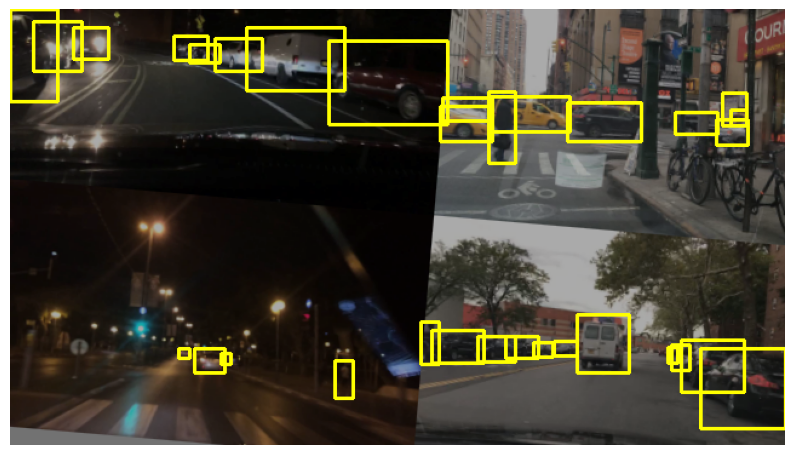

In [8]:
for iter in range(iter_start_offset, max_iters):

    # img, labels = dataset.__getitem__(iter)
    # img_path = labels['img_path']
    # img = img.unsqueeze(0).to(DEVICE)
    # bboxes = labels['bbox'].to(DEVICE)
    # clslabels = labels['obj_class_label'].to(DEVICE)

    img, labels = next(bdd_dataloader)
    img_path = labels['img_path']
    bboxes = labels['bbox_batch']
    clslabels = labels['obj_class_label']

    roi_features = prop_extractor(img)
    features = roi_features['features']
    queries = roi_features['queries']
    pred_boxes = roi_features['pred_boxes']
    pred_clsidx = roi_features['pred_clsidx']

    # roi_embedding = feat_embedding(roi_features['roi_features'])
    # query_embeddings = q_embedding(queries)
    # secondstage_pred = attention((roi_embedding, query_embeddings))
    predictions = detector((features, queries))

    groundtruths = gen_training_gt(
        gt_boxes = bboxes, 
        gt_class = clslabels,
        pred_boxes = pred_boxes,
        deltas_mean = torch.tensor(bdd_param_stage2.deltas_mean, dtype=torch.float32, device=DEVICE), 
        deltas_std = torch.tensor(bdd_param_stage2.deltas_std, dtype=torch.float32, device=DEVICE), 
        iou_threshold = bdd_param_stage2.iou_threshold,
        ignored_classId = bdd_param_stage2.ignored_classId)
    
    matched_gt_class = groundtruths.class_logits.clone()
    matched_gt_deltas = groundtruths.boxreg_deltas#.clone()
    matched_gt_objness = groundtruths.objness_logits#.clone()
    # matched_gt_boxes = groundtruths.bbox
    flag = [matched_gt_class >= 0]
    matched_gt_boxes = compute_bbox_from_offsets_normalized(
        (torch.concat(pred_boxes, dim=0))[flag],
        matched_gt_deltas[flag],
        torch.tensor(bdd_param_stage2.deltas_mean, dtype=torch.float32, device=DEVICE),
        torch.tensor(bdd_param_stage2.deltas_std, dtype=torch.float32, device=DEVICE))

    predicted_gt_class = predictions.class_logits#.clone()
    predicted_gt_deltas = predictions.boxreg_deltas#.clone()
    predicted_gt_objness = predictions.objness_logits#.clone()

    loss_vals = loss(predictions, groundtruths)
    print(loss_vals)

    print(matched_gt_class.shape)
    print(matched_gt_class)

    


    for b in range(BATCH_SIZE):


        # assoinfo = greedy_association(roi_features['pred_boxes'][b], bboxes[b], DEVICE)
        # proposal_gt_box_idx = assoinfo['proposal_gt_map']
        # proposal_gt_box_iou = assoinfo['proposal_gt_iou']
    
        # positive_flag = (proposal_gt_box_iou >= 0.2) & (proposal_gt_box_idx != -1)
        # negative_flag = ~positive_flag
        
        # proposal_gt_box_coord = bboxes[b][proposal_gt_box_idx]
        # proposal_gt_box_cls = clslabels[b][proposal_gt_box_idx]
        # proposal_gt_box_coord[negative_flag] = -1.0
        # proposal_gt_box_cls[negative_flag] = -1.0

        # invalid_bbox_flag = ~identify_prominent_objects(bboxes[b])
        # invalid_bbox_flag = invalid_bbox_flag[proposal_gt_box_idx]
        # ignored_classId = -99
        # ignored_flag = (proposal_gt_box_cls == ignored_classId) | ( invalid_bbox_flag & positive_flag )
        # proposal_gt_box_cls[ignored_flag] = -2.0

        # positive_flag = proposal_gt_box_cls >= 0
        # negative_flag = proposal_gt_box_cls == -1
        # ignored_flag = proposal_gt_box_cls == -2

        # # positive_boxes = proposal_gt_box_coord[positive_flag]
        # positive_boxes = roi_features['pred_boxes'][b][negative_flag]

        # # ignore some of the boxes:
        # # corrosponding to ignore class id
        # # gt box too small
        # # iou between the gt box and pred box is too small

        # print(proposal_gt_box_idx)
        # print(proposal_gt_box_iou)
        # print(proposal_gt_box_cls)
        # print(proposal_gt_box_coord)
        
        # positive_boxes = matched_gt_boxes[matched_gt_class >= 0].cpu().numpy()
        positive_boxes = matched_gt_boxes.cpu().numpy()
        # vizualize_bbox_resized(img_path[b], positive_boxes, bdd_param_obj.IMG_RESIZED_W, bdd_param_obj.IMG_RESIZED_H, figsize=(10,8))
        img_inv = inverse_norm(img[b])
        img_inv = (img_inv.permute(1,2,0).cpu().numpy() * 255).astype('uint8')
        draw_bbox_on_img_data(img_inv, positive_boxes, figsize=(10,8))

        














    
    # # pred_clsidx = roi_features['pred_clsidx'].cpu().numpy()
    # # pred_box = roi_features['pred_boxes'].cpu().numpy()
    # cls_prob = roi_features['pred_qualities'][:, :2].cpu().numpy()
    # obj_prob = roi_features['pred_qualities'][:, 2].cpu().numpy()
    # ctr_prob = roi_features['pred_qualities'][:, 3].cpu().numpy()

    # img_inv = inverse_norm(img)
    # img_inv = (img_inv.permute(0,2,3,1).cpu().numpy() * 255).astype('uint8')

    # print('==========> BATCH : ', iter, " <==========")
    # for b in range(BATCH_SIZE):
    #     print("-" * 100)
    #     print("image : ", b)
    #     print("-" * 100)
    #     print("image_path: ", img_path[b])
    #     # print("gt class_labels: ", clslabels[b])
    #     # print("gt bounding boxes: ")
    #     # print(bboxes[b])

    #     pred_clsidx = roi_features['pred_clsidx'][b].cpu().numpy()
    #     pred_box = roi_features['pred_boxes'][b].cpu().numpy()

    #     # vizualize_bbox_resized(img_path[b], pred_box, bdd_param_obj.IMG_RESIZED_W, bdd_param_obj.IMG_RESIZED_H, figsize=(10,8))
    #     draw_bbox_on_img_data(img_inv[b], pred_box, figsize=(10,8))
    #     # print('classification scores:')
    #     # print(cls_prob)
    #     # print('Objectness scores:')
    #     # print(obj_prob)
    #     # print('Centerness scores:')
    #     # print(ctr_prob)
    #     # print('Predicted box')
    #     # print(pred_box)

In [5]:
# print(roi_features['pred_boxes'].shape)
print(roi_features['pred_qualities'].shape)
print(roi_features['pred_boxes_norm_width'].shape)
print(roi_features['pred_boxes_norm_height'].shape)
for val in roi_features['roi_features'].values():
    print(val.shape)

torch.concat([
    roi_features['pred_qualities'], 
    roi_features['pred_boxes_norm_width'].unsqueeze(-1),
    roi_features['pred_boxes_norm_height'].unsqueeze(-1)], dim=-1)

KeyError: 'pred_qualities'

In [ ]:
query_embeddings.shape

NameError: name 'query_embeddings' is not defined

In [ ]:
cls, obj, reg = secondstage_pred
print(cls.shape)
print(obj.shape)
print(reg.shape)

torch.Size([199, 2])
torch.Size([199, 1])
torch.Size([199, 4])


In [ ]:
matched_gt_class = groundtruths.class_logits
matched_gt_deltas = groundtruths.boxreg_deltas
matched_gt_objness = groundtruths.objness_logits
matched_gt_boxes = groundtruths.bbox

In [ ]:
matched_gt_boxes

tensor([[  1.1583, 270.9539,  73.2509, 309.8011],
        [424.8185,  58.5111, 522.8316, 124.0714],
        [ 99.1569,  37.8696, 219.3636, 137.7881],
        [318.5098, 294.8016, 367.4760, 326.4837],
        [ 81.0799, 276.8299, 112.0698, 294.4580],
        [215.8397,  50.4084, 272.6148,  94.6860],
        [  0.0000,  59.4206, 101.1146, 134.2616],
        [454.0109, 295.9280, 475.1171, 314.0925],
        [356.6414, 297.7586, 389.1449, 318.8800],
        [378.5918, 297.1953, 400.9643, 314.2333],
        [ 83.1031,  66.0819, 104.2471,  79.4043],
        [ 67.0528, 281.4002,  87.9304, 301.3134],
        [549.1902,  78.6572, 570.1747,  90.9498],
        [244.1850, 271.6068, 264.0838, 284.6646],
        [283.9826, 273.2390, 305.5125, 287.9291],
        [304.2077, 271.2803, 317.9085, 288.5820],
        [106.5242, 277.8092, 122.1824, 290.2142],
        [227.2221, 273.2390, 253.3189, 286.6234],
        [151.5413, 275.1977, 161.9800, 284.0117],
        [126.0969, 278.4622, 133.2735, 285.3176],


In [ ]:
matched_gt_objness

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], device='cuda:0')